# Analysis of a Real Time Series using ARIMA

In this notebook we analyze a real economic time series following the methodology
requested in Assignment 2. We assess stationarity, apply transformations,
select an ARIMA model, perform forecasting, and analyze residuals.


In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm


import os
import sys

In [99]:
project_root = os.path.abspath("..")
src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    sys.path.append(src_path)

from utils import table_adf, table_kpss, arma_model_selection, significant_params, calculate_rmse
from plots import (
    plot_acf_sample, plot_pacf_sample,
    plot_residuals, plot_acf_pacf_residuals,
    arma_forecast_plot2, residuals_normality_test
)

In [100]:
data_path = os.path.join(project_root, "data", "raw")
file_path = os.path.join(data_path, "Desempleo.xls")

df = pd.read_excel(file_path, header=None)
df = df.iloc[4:191, 0:2]
df.columns = ["Date", "Value"]

df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df["Value"] = pd.to_numeric(df["Value"], errors="coerce")

df = df.dropna()
df.set_index("Date", inplace=True)

# Infer monthly frequency
df.index.freq = pd.infer_freq(df.index)

X = df["Value"]

In [101]:
print(X.index)
print(X.index.freq)

DatetimeIndex(['2010-03-01', '2010-04-01', '2010-05-01', '2010-06-01',
               '2010-07-01', '2010-08-01', '2010-09-01', '2010-10-01',
               '2010-11-01', '2010-12-01',
               ...
               '2024-12-01', '2025-01-01', '2025-02-01', '2025-03-01',
               '2025-04-01', '2025-05-01', '2025-06-01', '2025-07-01',
               '2025-08-01', '2025-09-01'],
              dtype='datetime64[ns]', name='Date', length=187, freq='MS')
<MonthBegin>


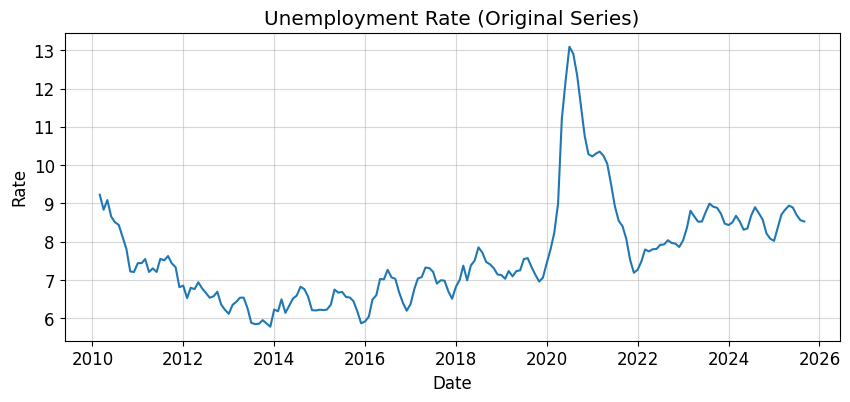

In [102]:
plt.figure(figsize=(10,4))
plt.plot(X)
plt.title("Unemployment Rate (Original Series)")
plt.xlabel("Date")
plt.ylabel("Rate")
plt.grid(True)
plt.show()

The series shows long-term movements and level changes, suggesting that the mean
is not constant over time. This is a first visual indication of non-stationarity.

In [103]:
table_adf(X)

,Statistic,p-value,Lags used,N obs,Crit (1%),Crit (5%),Crit (10%)
0,-2.269538,0.181981,10,176,-3.468062,-2.878106,-2.575602


In [104]:
table_kpss(X)

,Statistic,p-value,Lags used,Crit (10%),Crit (5%),Crit (2.5%),Crit (1%)
0,0.828083,0.01,9,0.347,0.463,0.574,0.739


The ADF test does not reject the null hypothesis of a unit root, while the KPSS test
rejects the null hypothesis of stationarity. Therefore, both tests indicate that the
series is not stationary in levels.

In [105]:
X_diff = X.diff().dropna()

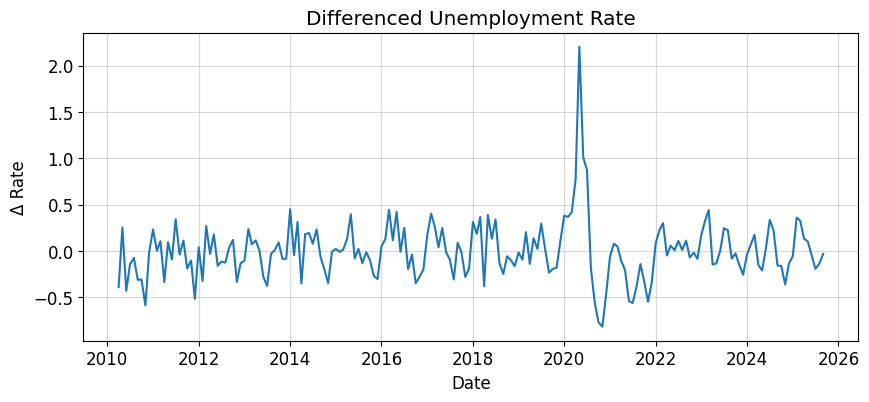

In [106]:
plt.figure(figsize=(10,4))
plt.plot(X_diff)
plt.title("Differenced Unemployment Rate")
plt.xlabel("Date")
plt.ylabel("Δ Rate")
plt.grid(True)
plt.show()

A first-order difference is applied to remove the non-stationary behavior observed
in the original series.

In [107]:
table_adf(X_diff)

,Statistic,p-value,Lags used,N obs,Crit (1%),Crit (5%),Crit (10%)
0,-3.935618,0.001788,9,176,-3.468062,-2.878106,-2.575602


In [108]:
table_kpss(X_diff)

,Statistic,p-value,Lags used,Crit (10%),Crit (5%),Crit (2.5%),Crit (1%)
0,0.093747,0.1,5,0.347,0.463,0.574,0.739


After first-order differencing, the ADF test rejects the null hypothesis of a unit root,
while the KPSS test no longer rejects stationarity. Hence, the differenced series is
stationary.


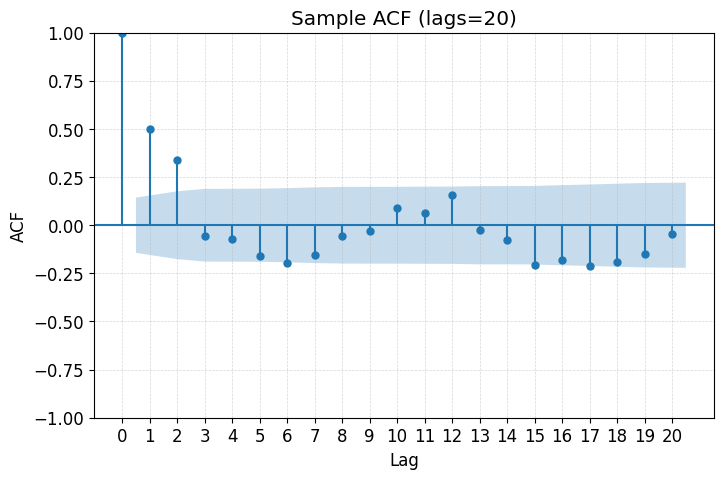

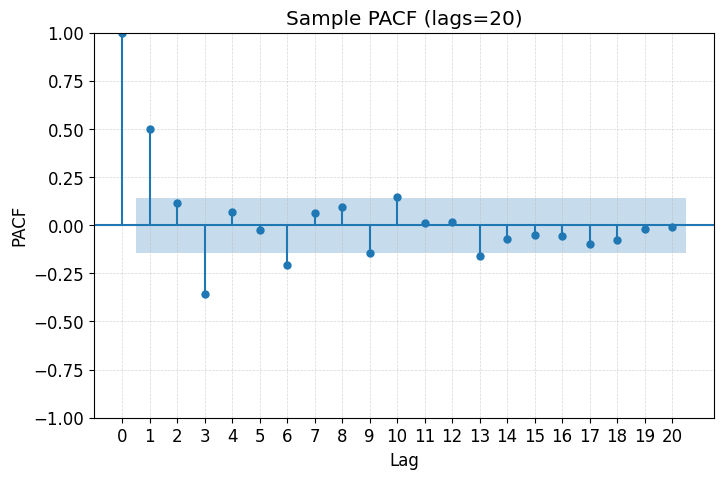

In [109]:
plot_acf_sample(X_diff, lags=20)
plot_pacf_sample(X_diff, lags=20)

The ACF and PACF of the differenced series suggest short-memory dynamics, supporting
the use of an ARMA-type structure for the stationary component.


In [110]:
model_selection = arma_model_selection(X_diff)
model_selection.sort_values("AIC").head()

C:\Users\edgar\.conda\envs\Assignment_2\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\edgar\.conda\envs\Assignment_2\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\edgar\.conda\envs\Assignment_2\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\edgar\.conda\envs\Assignment_2\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Us

,p,q,AIC,BIC,LogLik
0,1,3,13.294985,32.649465,-0.647492
1,1,2,13.687648,29.816382,-1.843824
2,2,3,13.935407,36.515634,0.032296
3,0,3,14.266057,30.394790,-2.133028
4,0,2,14.578325,27.481312,-3.289163


Candidate ARIMA models are evaluated using information criteria (AIC and BIC).
The most parsimonious model among those with the lowest information criteria is selected.

Although a convergence warning was issued, parameter estimates remain stable and interpretable.

In [111]:
model = ARIMA(X, order=(1,1,1)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Value   No. Observations:                  187
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -21.047
Date:                Mon, 15 Dec 2025   AIC                             48.094
Time:                        11:18:27   BIC                             57.771
Sample:                    03-01-2010   HQIC                            52.016
                         - 09-01-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5725      0.095      6.007      0.000       0.386       0.759
ma.L1         -0.0915      0.128     -0.713      0.476      -0.343       0.160
sigma2         0.0733      0.005     16.110      0.000       0.064       0.082
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):               756.07
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                             1.48
Prob(H) (two-sided):                  0.42   Kurtosis:                        12.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The MA component is not statistically significant, suggesting that a simpler ARIMA(1,1,0) model could also be considered.

In [112]:
significant_params(model)

Significant at 5.0% level:
            coef   std_err        pvalue
ar.L1   0.572474  0.095306  1.893100e-09
sigma2  0.073299  0.004550  2.156274e-58

Not significant at 5.0% level:
           coef   std_err    pvalue
ma.L1 -0.091533  0.128432  0.476033


In [113]:
split = int(len(X) * 0.8)

X_train = X.iloc[:split]
X_test  = X.iloc[split:]

In [114]:
model_train = ARIMA(X_train, order=(1,1,1)).fit()

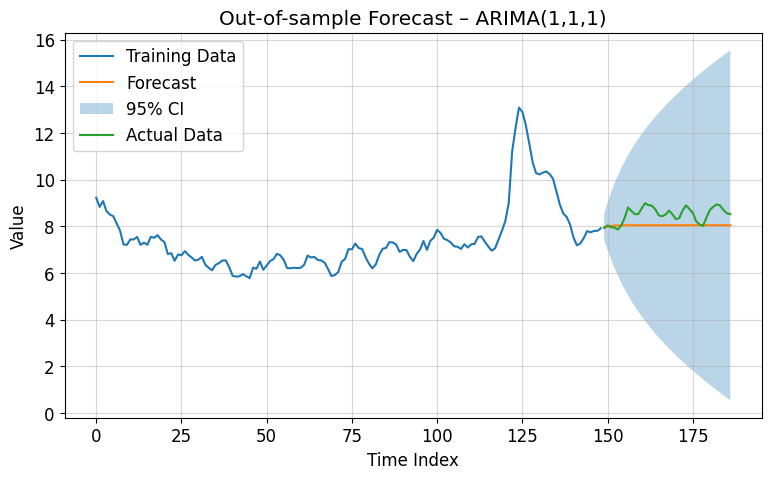

(2022-08-01    7.970904
 2022-09-01    8.002446
 2022-10-01    8.021545
 2022-11-01    8.033109
 2022-12-01    8.040111
 2023-01-01    8.044351
 2023-02-01    8.046918
 2023-03-01    8.048473
 2023-04-01    8.049414
 2023-05-01    8.049984
 2023-06-01    8.050329
 2023-07-01    8.050538
 2023-08-01    8.050665
 2023-09-01    8.050741
 2023-10-01    8.050788
 2023-11-01    8.050816
 2023-12-01    8.050833
 2024-01-01    8.050843
 2024-02-01    8.050849
 2024-03-01    8.050853
 2024-04-01    8.050855
 2024-05-01    8.050857
 2024-06-01    8.050857
 2024-07-01    8.050858
 2024-08-01    8.050858
 2024-09-01    8.050858
 2024-10-01    8.050859
 2024-11-01    8.050859
 2024-12-01    8.050859
 2025-01-01    8.050859
 2025-02-01    8.050859
 2025-03-01    8.050859
 2025-04-01    8.050859
 2025-05-01    8.050859
 2025-06-01    8.050859
 2025-07-01    8.050859
 2025-08-01    8.050859
 2025-09-01    8.050859
 Freq: MS, Name: predicted_mean, dtype: float64,
             lower Value  upper Value
 

In [115]:
arma_forecast_plot2(
    model_train,
    X_train,
    X_test,
    steps=len(X_test),
    title="Out-of-sample Forecast – ARIMA(1,1,1)"
)

In [116]:
# In-sample RMSE
fitted_train = model_train.fittedvalues

rmse_train = np.sqrt(
    mean_squared_error(
        X_train.iloc[1:],      # first obs lost due to differencing
        fitted_train.iloc[1:]
    )
)
# Out-of-sample RMSE
forecast_res = model_train.get_forecast(steps=len(X_test))
forecast_test = forecast_res.predicted_mean

rmse_test = np.sqrt(
    mean_squared_error(X_test, forecast_test)
)
rmse_train, rmse_test

(np.float64(0.29039872768260655), np.float64(0.5542114479913215))

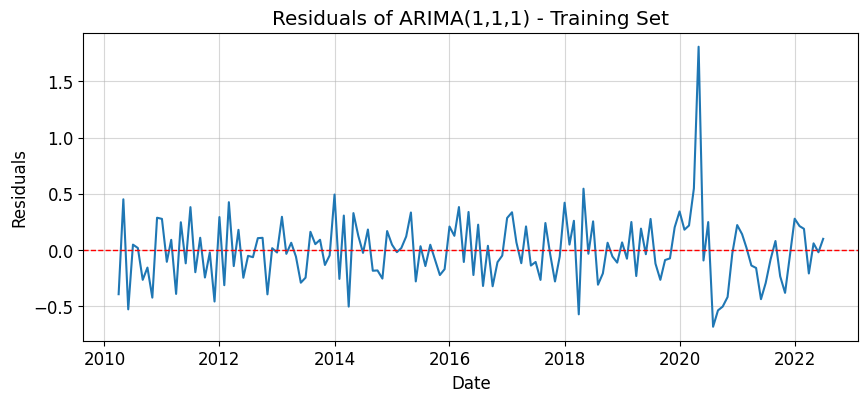

In [118]:
resid = model_train.resid.iloc[1:]

plt.figure(figsize=(10,4))
plt.plot(resid)
plt.title("Residuals of ARIMA(1,1,1) - Training Set")
plt.xlabel("Date")
plt.ylabel("Residuals")
plt.axhline(0, color='red', linestyle='--', linewidth=1) # Línea en cero de referencia
plt.grid(True)
plt.show()

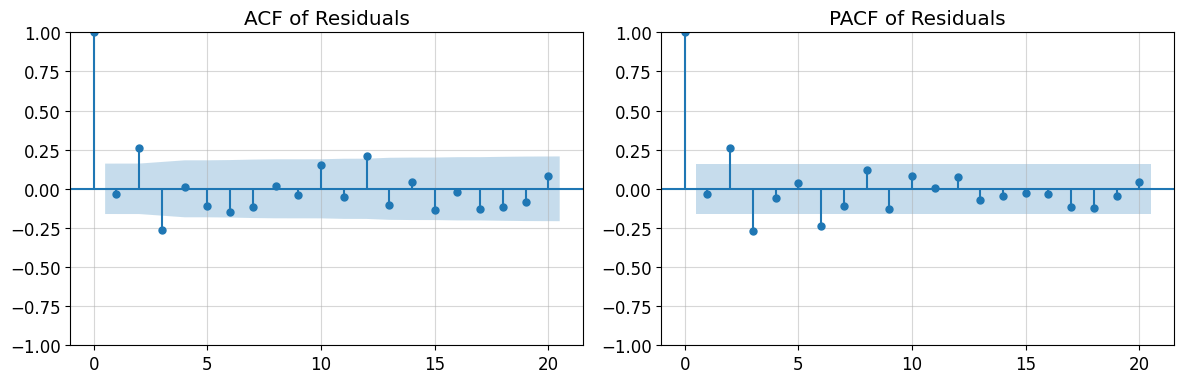

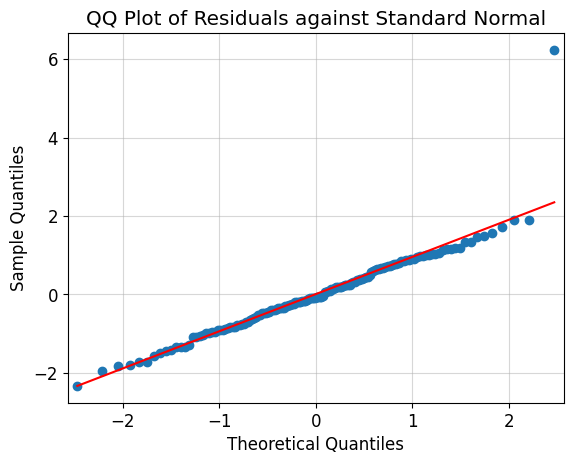

In [120]:
plot_acf_pacf_residuals(resid, lags=20)

fig = sm.qqplot(resid, line='q', fit=True)
plt.title("QQ Plot of Residuals against Standard Normal")
plt.grid(True)
plt.show()


Ljung-Box Test (White Noise Check):
      lb_stat  lb_pvalue
10  32.596707   0.000318
15  45.124979   0.000073
20  52.748780   0.000088

Normality Test (Jarque-Bera):


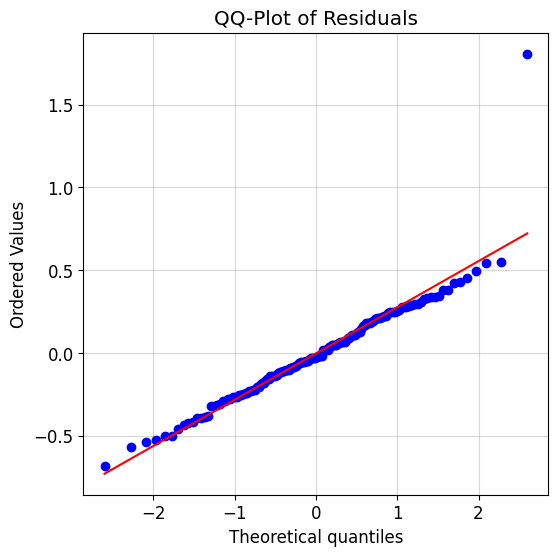

Shapiro-Wilk Test:
Statistic: 0.9087, p-value: 0.0000

Jarque-Bera Test:
Statistic: 515.3794, p-value: 0.0000


{'shapiro_stat': np.float64(0.9087179127231344),
 'shapiro_pvalue': np.float64(4.9953189748434436e-08),
 'jb_stat': np.float64(515.379418819773),
 'jb_pvalue': np.float64(1.2211841532840686e-112)}

In [121]:
lb_test = acorr_ljungbox(resid, lags=[10, 15, 20], return_df=True)
print("\nLjung-Box Test (White Noise Check):")
print(lb_test)

print("\nNormality Test (Jarque-Bera):")
residuals_normality_test(resid)

## Conclusions

This work analyzed a real monthly unemployment time series using ARIMA models. An initial visual inspection and formal stationarity tests (ADF and KPSS) showed that the original series was non-stationary in levels, exhibiting long-term movements and changes in its mean.

To address this issue, a first-order difference was applied. After differencing, the ADF test rejected the null hypothesis of a unit root and the KPSS test no longer rejected stationarity, confirming that the transformed series is stationary. This justified the use of an ARMA-type structure for the differenced process and, consequently, an ARIMA model for the original series.

Based on the analysis of the ACF and PACF plots and the comparison of candidate models using information criteria, an ARIMA(1,1,1) model was selected. This specification provided the best balance between model parsimony and information loss (AIC), capturing the primary linear dynamics of the series.

However, diagnostic checks on the residuals revealed significant limitations. The **Ljung-Box test rejected the hypothesis of white noise**, and the **Jarque-Bera test strongly rejected normality**, indicating the presence of autocorrelation and heavy tails. Visual inspection of the residuals suggests that these violations are largely driven by extreme exogenous shocks (outliers), particularly during the 2020 period (COVID-19 pandemic), which a standard Gaussian ARIMA model cannot fully assimilate.

Finally, regarding forecasting performance, the model captured the general level of the series in the out-of-sample test. However, the RMSE in the test set was nearly double that of the training set ($0.55$ vs $0.29$). This deterioration in accuracy, combined with the diagnostic results, highlights the complexity of the dataset and suggests that while the ARIMA model offers a valid baseline, the series exhibits volatility clustering that might require more advanced approaches (such as intervention analysis or GARCH models) for precise modeling.